<a href="https://colab.research.google.com/github/empathy4924/Potato_leaf_disease_severity/blob/main/notebooks/01_dataset_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


### Confirm ZIP Exists in Drive

In [ ]:
import os

zip_path = "/content/drive/MyDrive/PotatoDataset.zip"

print("ZIP exists:", os.path.exists(zip_path))


ZIP exists: True


### Unzip PotatoDataset.zip in Drive

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/PotatoDataset.zip"
extract_path = "/content/drive/MyDrive/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
dataset_path = "/content/drive/MyDrive/PotatoDataset"

print("Dataset folder exists:", os.path.exists(dataset_path))
print("Images folder exists:", os.path.exists(dataset_path + "/images"))
print("Labels folder exists:", os.path.exists(dataset_path + "/labels"))


Dataset folder exists: True
Images folder exists: True
Labels folder exists: True


## Convert all images to JPG

In [ ]:
import os
from PIL import Image

# Input folders
images_dir = "/content/drive/MyDrive/PotatoDataset/images"
labels_dir = "/content/drive/MyDrive/PotatoDataset/labels"

# Output standardized folders
new_images_dir = "/content/drive/MyDrive/PotatoDataset_JPG/images"
new_labels_dir = "/content/drive/MyDrive/PotatoDataset_JPG/labels"

os.makedirs(new_images_dir, exist_ok=True)
os.makedirs(new_labels_dir, exist_ok=True)

converted = 0
skipped = 0

for img_file in os.listdir(images_dir):

    # Only process image formats
    if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    # Base name (without extension)
    base_name = os.path.splitext(img_file)[0]

    # Corresponding label file
    label_file = base_name + ".txt"

    # Skip if label missing
    if not os.path.exists(os.path.join(labels_dir, label_file)):
        skipped += 1
        continue

    # Open image
    img_path = os.path.join(images_dir, img_file)
    img = Image.open(img_path).convert("RGB")

    # Save as JPG
    new_img_path = os.path.join(new_images_dir, base_name + ".jpg")
    img.save(new_img_path, "JPEG", quality=95)

    # Copy label file
    old_label_path = os.path.join(labels_dir, label_file)
    new_label_path = os.path.join(new_labels_dir, label_file)

    with open(old_label_path, "r") as f:
        label_data = f.read()

    with open(new_label_path, "w") as f:
        f.write(label_data)

    converted += 1

print("Conversion completed!")
print("Converted images:", converted)
print("Skipped (missing labels):", skipped)
print("New standardized dataset saved in PotatoDataset_JPG/")


Conversion completed!
Converted images: 2283
Skipped (missing labels): 0
New standardized dataset saved in PotatoDataset_JPG/


## Count Total Instances Per Class (Full Dataset)

In [ ]:
class_names = {
    0: "Healthy",
    1: "Bacterial",
    2: "Fungal",
    3: "Viral",
    4: "Nematode",
    5: "Pest",
    6: "Phytophthora"
}


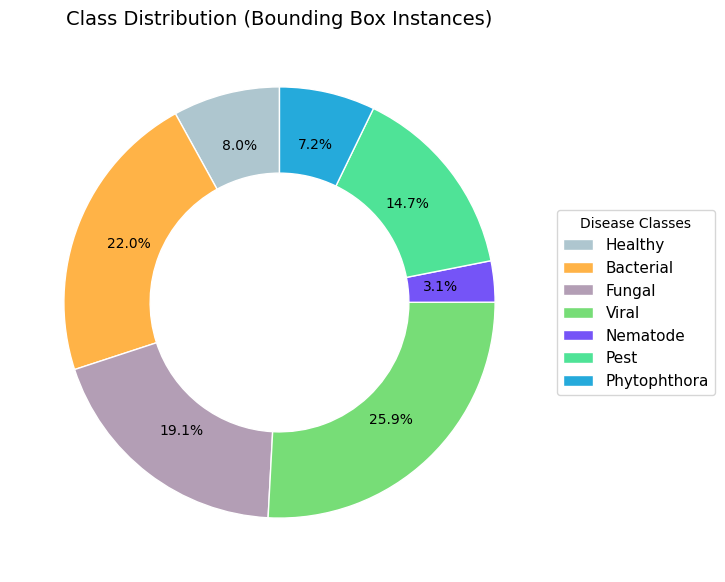

Chart saved at: /content/drive/MyDrive/Results/donut_class_distribution.png


In [ ]:
import os
import matplotlib.pyplot as plt

# Class name mapping
class_names = {
    0: "Healthy",
    1: "Bacterial",
    2: "Fungal",
    3: "Viral",
    4: "Nematode",
    5: "Pest",
    6: "Phytophthora"
}

# Light pastel colors
pastel_colors = [
    "#AEC6CF",  # light blue
    "#FFB347",  # light orange
    "#B39EB5",  # light purple
    "#77DD77",  # light green
    "#7554f7",  # light red
    "#4fe397",  # light yellow
    "#25AADB"   # light gray
]

# Prepare labels, sizes, colors
labels = []
sizes = []
colors = []

for cls, count in sorted(class_counts.items()):
    labels.append(class_names[cls])
    sizes.append(count)
    colors.append(pastel_colors[cls])

# Create Results folder in Drive
results_dir = "/content/drive/MyDrive/Results"
os.makedirs(results_dir, exist_ok=True)

# Plot donut chart
plt.figure(figsize=(9,7))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=None,                 # remove labels from slices
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops={"width": 0.4, "edgecolor": "white"},
    pctdistance=0.75             # percentage inside donut
)

# Add legend on the right side
plt.legend(
    wedges,
    labels,
    title="Disease Classes",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=11
)

plt.title("Class Distribution (Bounding Box Instances)", fontsize=14)

# Save figure to Drive
save_path = os.path.join(results_dir, "donut_class_distribution.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

print("Chart saved at:", save_path)


In [ ]:
import os
from collections import Counter
# Class ID → Class Name mapping
class_names = {
    0: "Healthy",
    1: "Bacterial",
    2: "Fungal",
    3: "Viral",
    4: "Nematode",
    5: "Pest",
    6: "Phytophthora"
}

labels_dir = "/content/drive/MyDrive/PotatoDataset_JPG/labels"

class_counts = Counter()

for file in os.listdir(labels_dir):
    if not file.endswith(".txt"):
        continue

    with open(os.path.join(labels_dir, file), "r") as f:
        for line in f.readlines():
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

print("Total bounding box instances per class (full dataset):")
for cls, count in sorted(class_counts.items()):
    print("Class", cls, ":", count)


Total bounding box instances per class (full dataset):
Class 0 : 333
Class 1 : 914
Class 2 : 794
Class 3 : 1074
Class 4 : 128
Class 5 : 611
Class 6 : 298


## Step 0: Define Paths

In [ ]:
import os
import random
import shutil
from collections import Counter, defaultdict

base_dir = "/content/drive/MyDrive/PotatoDataset_JPG"

images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

output_dir = "/content/drive/MyDrive/PotatoSplit_Stratified"


## Step 1: Assign Each Image to Its Majority Class

In [ ]:
image_to_class = {}

for img_file in os.listdir(images_dir):

    if not img_file.lower().endswith(".jpg"):
        continue

    label_file = img_file.replace(".jpg", ".txt")
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    box_classes = []

    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id = int(line.split()[0])
            box_classes.append(class_id)

    if len(box_classes) == 0:
        continue

    majority_class = Counter(box_classes).most_common(1)[0][0]
    image_to_class[img_file] = majority_class

print("Total labeled images:", len(image_to_class))


Total labeled images: 2281


## Step 2: Group Images by Class

In [ ]:
class_groups = defaultdict(list)

for img, cls in image_to_class.items():
    class_groups[cls].append(img)

for cls in sorted(class_groups.keys()):
    print("Class", cls, "images:", len(class_groups[cls]))


Class 0 images: 196
Class 1 images: 347
Class 2 images: 562
Class 3 images: 428
Class 4 images: 66
Class 5 images: 420
Class 6 images: 262


In [ ]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_files, val_files, test_files = [], [], []

for cls, imgs in class_groups.items():

    random.shuffle(imgs)

    total = len(imgs)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    train_files.extend(imgs[:train_end])
    val_files.extend(imgs[train_end:val_end])
    test_files.extend(imgs[val_end:])

print("Split completed")
print("Training images:", len(train_files))
print("Validation images:", len(val_files))
print("Testing images:", len(test_files))


Split completed
Training images: 1594
Validation images: 455
Testing images: 232


In [ ]:
splits = ["train", "val", "test"]

for split in splits:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

print("Output folders created at:", output_dir)


Output folders created at: /content/drive/MyDrive/PotatoSplit_Stratified


In [ ]:
def copy_split(file_list, split_name):

    for img_file in file_list:

        label_file = img_file.replace(".jpg", ".txt")

        src_img = os.path.join(images_dir, img_file)
        src_lbl = os.path.join(labels_dir, label_file)

        dst_img = os.path.join(output_dir, "images", split_name, img_file)
        dst_lbl = os.path.join(output_dir, "labels", split_name, label_file)

        shutil.copy(src_img, dst_img)
        shutil.copy(src_lbl, dst_lbl)

copy_split(train_files, "train")
copy_split(val_files, "val")
copy_split(test_files, "test")

print("Stratified dataset saved successfully.")


Stratified dataset saved successfully.


In [ ]:
import os
from collections import Counter

splits = ["train", "val", "test"]
base_split_dir = "/content/drive/MyDrive/PotatoSplit_Stratified/labels"

for split in splits:

    label_dir = os.path.join(base_split_dir, split)

    image_count_per_class = Counter()
    instance_count_per_class = Counter()

    for file in os.listdir(label_dir):

        if not file.endswith(".txt"):
            continue

        classes_in_image = set()

        with open(os.path.join(label_dir, file), "r") as f:
            for line in f.readlines():
                class_id = int(line.split()[0])

                instance_count_per_class[class_id] += 1
                classes_in_image.add(class_id)

        for cls in classes_in_image:
            image_count_per_class[cls] += 1

    print("\nSplit:", split)
    print("Images per class:")
    for cls, count in sorted(image_count_per_class.items()):
        print("  Class", cls, ":", count)

    print("Instances per class (bounding boxes):")
    for cls, count in sorted(instance_count_per_class.items()):
        print("  Class", cls, ":", count)



Split: train
Images per class:
  Class 0 : 137
  Class 1 : 242
  Class 2 : 393
  Class 3 : 299
  Class 4 : 46
  Class 5 : 294
  Class 6 : 183
Instances per class (bounding boxes):
  Class 0 : 238
  Class 1 : 649
  Class 2 : 554
  Class 3 : 750
  Class 4 : 89
  Class 5 : 427
  Class 6 : 207

Split: val
Images per class:
  Class 0 : 39
  Class 1 : 70
  Class 2 : 112
  Class 3 : 86
  Class 4 : 13
  Class 5 : 83
  Class 6 : 52
Instances per class (bounding boxes):
  Class 0 : 68
  Class 1 : 185
  Class 2 : 154
  Class 3 : 211
  Class 4 : 23
  Class 5 : 116
  Class 6 : 57

Split: test
Images per class:
  Class 0 : 20
  Class 1 : 35
  Class 2 : 57
  Class 3 : 43
  Class 4 : 7
  Class 5 : 43
  Class 6 : 27
Instances per class (bounding boxes):
  Class 0 : 27
  Class 1 : 80
  Class 2 : 86
  Class 3 : 113
  Class 4 : 16
  Class 5 : 68
  Class 6 : 34


### Create Dataset YAML File

In [ ]:
yaml_text = """
path: /content/drive/MyDrive/PotatoSplit_Stratified

train: images/train
val: images/val
test: images/test

nc: 7

names:
  0: Healthy
  1: Bacterial
  2: Fungal
  3: Viral
  4: Nematode
  5: Pest
  6: Phytophthora
"""

yaml_path = "/content/drive/MyDrive/PotatoSplit_Stratified/potato.yaml"

with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("YAML saved at:", yaml_path)


YAML saved at: /content/drive/MyDrive/PotatoSplit_Stratified/potato.yaml


# Dataset Audit + Quality Control

### Check class imbalance

In [ ]:
from collections import Counter
import os

train_labels_path = "/content/drive/MyDrive/PotatoSplit_Stratified/labels/train"

class_counts = Counter()

for file in os.listdir(train_labels_path):
    with open(os.path.join(train_labels_path, file), "r") as f:
        for line in f.readlines():
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

print("📌 Class Distribution (Training Set):")
for cls, count in class_counts.items():
    print(f"Class {cls}: {count} bounding boxes")


📌 Class Distribution (Training Set):
Class 1: 649 bounding boxes
Class 2: 554 bounding boxes
Class 0: 238 bounding boxes
Class 4: 89 bounding boxes
Class 5: 427 bounding boxes
Class 6: 207 bounding boxes
Class 3: 750 bounding boxes


### Find Which Image Has Class 7

In [ ]:
import os

train_labels_path = "/content/drive/MyDrive/PotatoSplit_Stratified/labels/train"

problem_files = []

for file in os.listdir(train_labels_path):
    file_path = os.path.join(train_labels_path, file)

    with open(file_path, "r") as f:
        for line in f.readlines():
            class_id = int(line.split()[0])

            if class_id == 7:
                problem_files.append(file)
                break

print("Files containing class 7:", problem_files)


Files containing class 7: []


### Bounding Box Size Check

In [ ]:
import numpy as np

box_widths, box_heights = [], []

for file in os.listdir(train_labels_path):
    with open(os.path.join(train_labels_path, file), "r") as f:
        for line in f.readlines():
            _, xc, yc, w, h = line.split()
            box_widths.append(float(w))
            box_heights.append(float(h))

print("Average Width:", np.mean(box_widths))
print("Average Height:", np.mean(box_heights))
print("Small boxes (<0.02):", sum(w < 0.02 for w in box_widths))


Average Width: 0.41827865442690465
Average Height: 0.4292097810569664
Small boxes (<0.02): 0


In [ ]:
print("Min width:", min(box_widths))
print("Max width:", max(box_widths))
print("Min height:", min(box_heights))
print("Max height:", max(box_heights))


Min width: 0.052667
Max width: 0.999333
Min height: 0.050667
Max height: 0.998667


In [ ]:
large_boxes = [w for w in box_widths if w > 0.95]
print("Boxes with width > 0.95:", len(large_boxes))

large_boxes_h = [h for h in box_heights if h > 0.95]
print("Boxes with height > 0.95:", len(large_boxes_h))


Boxes with width > 0.95: 50
Boxes with height > 0.95: 41


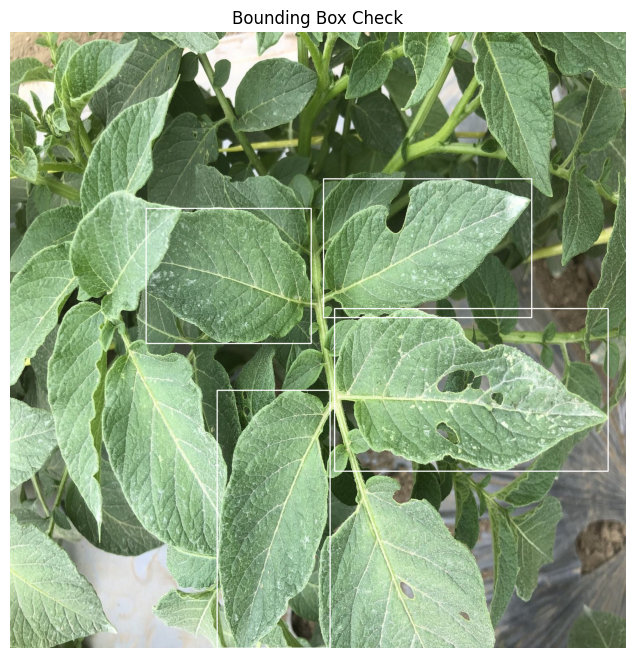

In [ ]:
import cv2, random
import matplotlib.pyplot as plt

img_folder = "/content/drive/MyDrive/PotatoSplit/images/train"
lbl_folder = "/content/drive/MyDrive/PotatoSplit/labels/train"

sample_img = random.choice(os.listdir(img_folder))

image = cv2.imread(os.path.join(img_folder, sample_img))
h, w, _ = image.shape

label_file = sample_img.replace(".jpg", ".txt").replace(".png", ".txt")

with open(os.path.join(lbl_folder, label_file), "r") as f:
    for line in f.readlines():
        cls, xc, yc, bw, bh = map(float, line.split())

        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (255,255,255), 2)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Bounding Box Check")
plt.show()
